<a href="https://colab.research.google.com/github/Ayaan577/Video-Based-HRNG/blob/main/Video_based_HRNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opencv-python numpy scipy pycryptodome matplotlib


In [24]:
import cv2
import numpy as np
import seaborn as sns
import hashlib
import os
from scipy.stats import binomtest, norm
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import matplotlib.pyplot as plt

In [5]:
video_path = "/content/videoplayback.mp4"

In [6]:
def process_video(video_path, frame_skip=10, resize_factor=0.1):
    """
    Extracts randomness from video frames.
    - Uses grayscale frames
    - Normalizes pixel values
    - Applies Von Neumann debiasing
    - Further reduces bias using XOR folding and SHA-256 hashing
    """
    cap = cv2.VideoCapture(video_path)
    raw_bitstream = []

    while cap.isOpened():
        for _ in range(frame_skip):
            cap.read()  # Skip frames to reduce correlation
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        small_frame = cv2.resize(gray_frame, (0, 0), fx=resize_factor, fy=resize_factor)

        normalized_frame = small_frame / 255.0
        bitstream = (normalized_frame > 0.5).astype(int)
        raw_bitstream.extend(bitstream.flatten())

    cap.release()

    # Apply Von Neumann Debiasing
    unbiased_bitstream = apply_von_neumann_correction(raw_bitstream)

    # Apply XOR Folding
    unbiased_bitstream = xor_fold(unbiased_bitstream)

    # Apply SHA-256 Hashing as Extractor
    unbiased_bitstream = extract_entropy(unbiased_bitstream)

    return unbiased_bitstream


In [7]:
"""Applies Von Neumann correction to remove bias."""
def apply_von_neumann_correction(bitstream):
    corrected_bits = []
    for i in range(0, len(bitstream) - 1, 2):
        if bitstream[i] != bitstream[i + 1]:  # 01 -> 0, 10 -> 1
            corrected_bits.append(bitstream[i])
    return np.array(corrected_bits, dtype=np.uint8)


In [8]:
"""Reduces bias further by XOR-ing adjacent bits."""
def xor_fold(bitstream):
    return np.bitwise_xor(bitstream[:-1], bitstream[1:])


In [9]:
"""Applies SHA-256 hashing to remove remaining bias."""
def extract_entropy(bitstream, chunk_size=512):1
    extracted_bits = []
    for i in range(0, len(bitstream), chunk_size):
        chunk = bitstream[i:i+chunk_size]
        if len(chunk) < chunk_size:
            break
        hash_val = hashlib.sha256(bytes(chunk)).digest()
        extracted_bits.extend(np.unpackbits(np.frombuffer(hash_val, dtype=np.uint8)))
    return np.array(extracted_bits, dtype=np.uint8)


In [10]:
"""Performs frequency and runs tests to validate randomness."""
def randomness_tests(bitstream):
    n = len(bitstream)
    ones_count = np.sum(bitstream)
    zeros_count = n - ones_count

    prop_ones = ones_count / n
    prop_zeros = zeros_count / n

    # Frequency (Monobit) Test
    freq_test_p = binomtest(ones_count, n, 0.5, alternative='two-sided').pvalue
    freq_test_pass = freq_test_p > 0.01

    # Shannon Entropy Calculation
    p1 = prop_ones if prop_ones > 0 else 1e-10
    p0 = prop_zeros if prop_zeros > 0 else 1e-10
    entropy = - (p1 * np.log2(p1) + p0 * np.log2(p0))

    # Runs Test
    runs = 1 + np.sum(bitstream[:-1] != bitstream[1:])
    expected_runs = (2 * ones_count * zeros_count) / n + 1
    std_dev = np.sqrt((2 * ones_count * zeros_count) * (2 * ones_count * zeros_count - n) / (n**2 * (n - 1)))
    z_score = (runs - expected_runs) / std_dev
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    runs_test_pass = p_value > 0.01

    print("\n--- Randomness Validation ---")
    print(f"Length of Raw Bitstream: {n * 2}")  # Before von Neumann correction
    print(f"Length of Unbiased Bitstream: {n}")
    print(f"Proportion of 1s: {prop_ones:.6f}")
    print(f"Proportion of 0s: {prop_zeros:.6f}")
    print(f"Frequency Test: {'PASSED' if freq_test_pass else 'FAILED'}")
    print(f"Shannon Entropy: {entropy:.6f}")
    print(f"Runs: {runs}, Expected Runs: {expected_runs:.2f}, Z-Score: {z_score:.2f}, P-Value: {p_value:.6f}")
    print(f"Runs Test: {'PASSED' if runs_test_pass else 'FAILED'}")

    return freq_test_pass and runs_test_pass


In [11]:
"""Encrypts a message using AES-256."""
def encrypt(message, key):
    iv = os.urandom(16)  # 16 bytes IV
    cipher = AES.new(key, AES.MODE_CBC, iv)
    ciphertext = cipher.encrypt(pad(message.encode(), AES.block_size))
    return ciphertext.hex(), iv.hex()

"""Decrypts AES-256 encrypted data."""
def decrypt(ciphertext, key, iv):
    cipher = AES.new(key, AES.MODE_CBC, bytes.fromhex(iv))
    decrypted = unpad(cipher.decrypt(bytes.fromhex(ciphertext)), AES.block_size)
    return decrypted.decode()


In [20]:
# Step 1: Extract random bits
unbiased_bitstream = process_video(video_path)

# Step 2: Validate randomness
if not randomness_tests(unbiased_bitstream):
    print("\n WARNING: Randomness tests failed! Do not use the key for encryption.")
else:
    print("\n Randomness tests passed!")

# Step 3: Generate a 256-bit key
key_bits = unbiased_bitstream[:256]
key_bytes = np.packbits(key_bits)[:32]
key = bytes(key_bytes)

# Step 4: AES Encryption and Decryption
message = "This is a secure message."
ciphertext, iv = encrypt(message, key)
decrypted_message = decrypt(ciphertext, key, iv)

# Print Results
print("\n--- Encryption Results ---")
print(f"Generated Key: {key.hex()}")
print(f"Ciphertext: {ciphertext}")
print(f"IV: {iv}")
print(f"Decrypted Message: {decrypted_message}")




--- Randomness Validation ---
Length of Raw Bitstream: 13312
Length of Unbiased Bitstream: 6656
Proportion of 1s: 0.491587
Proportion of 0s: 0.508413
Frequency Test: PASSED
Shannon Entropy: 0.999796
Runs: 3232, Expected Runs: 3328.06, Z-Score: -2.36, P-Value: 0.018490
Runs Test: PASSED

 Randomness tests passed!

--- Encryption Results ---
Generated Key: 70a300a6279e253c85b518c39a2f5012f07cc0f4b81d2c2d0b3b5d978f6910c1
Ciphertext: 8b534450114f9eed2cccdd395222feeeccd4f61a3b7c44936732a94f4e41ea4a
IV: f1ed11c1942fa266fd680db1051e9a85
Decrypted Message: This is a secure message.


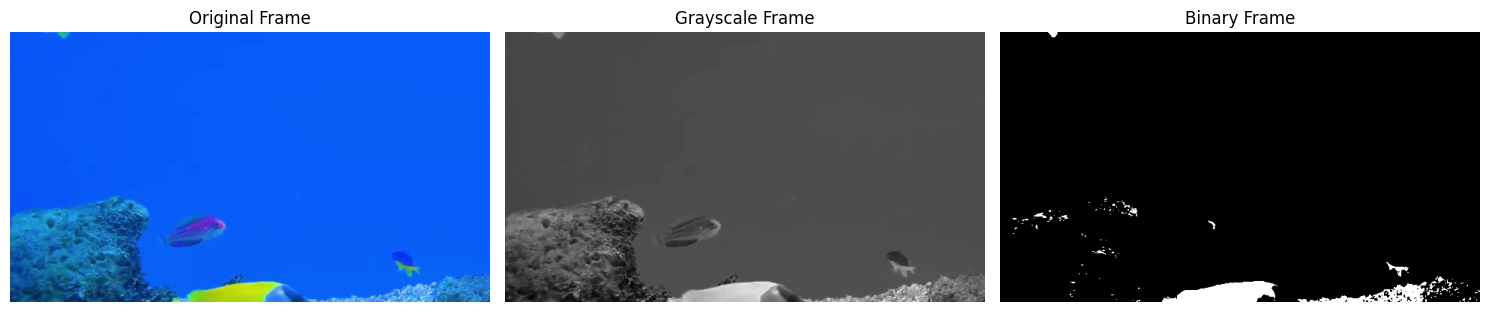

In [28]:
def show_processing_stages(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary_frame = cv2.threshold(gray_frame, 127, 255, cv2.THRESH_BINARY)

    plt.figure(figsize=(15, 5))
    titles = ["Original Frame", "Grayscale Frame", "Binary Frame"]
    images = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), gray_frame, binary_frame]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i], cmap="gray" if i > 0 else None)
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
video_path = r"/content/videoplayback.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if ret:
    show_processing_stages(frame)
cap.release()


<ipython-input-25-d07860b41f1e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["0s", "1s"], y=[zeros_count, ones_count], palette="pastel")


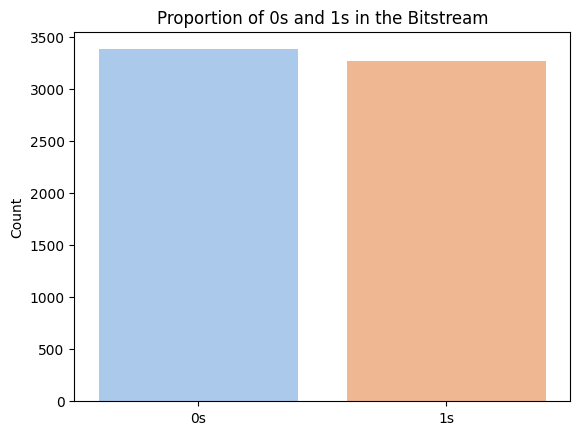

In [25]:
def plot_proportions(bitstream):
    ones_count = np.sum(bitstream)
    zeros_count = len(bitstream) - ones_count

    sns.barplot(x=["0s", "1s"], y=[zeros_count, ones_count], palette="pastel")
    plt.title("Proportion of 0s and 1s in the Bitstream")
    plt.ylabel("Count")
    plt.show()

plot_proportions(unbiased_bitstream)

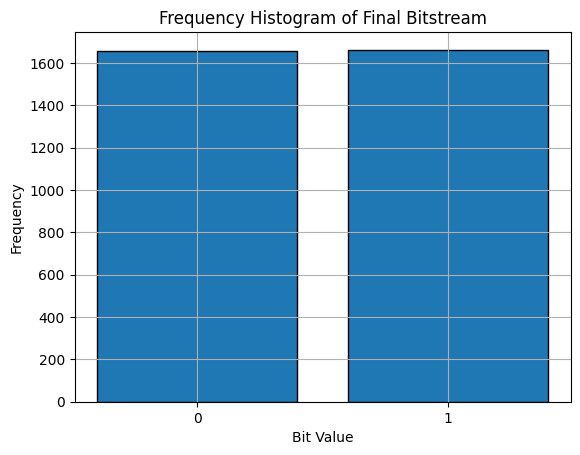

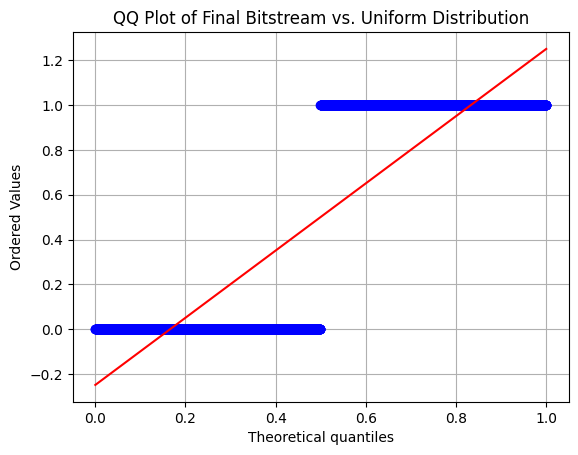

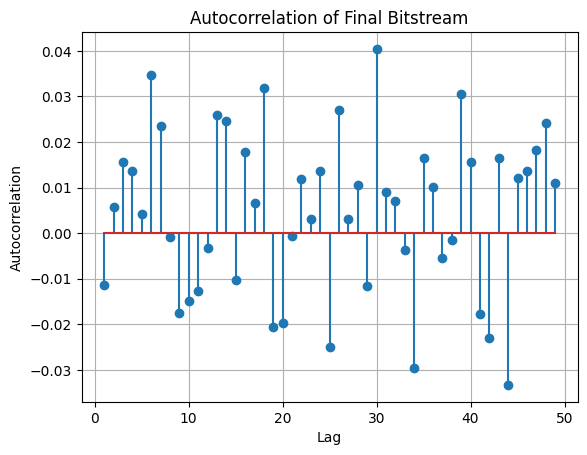

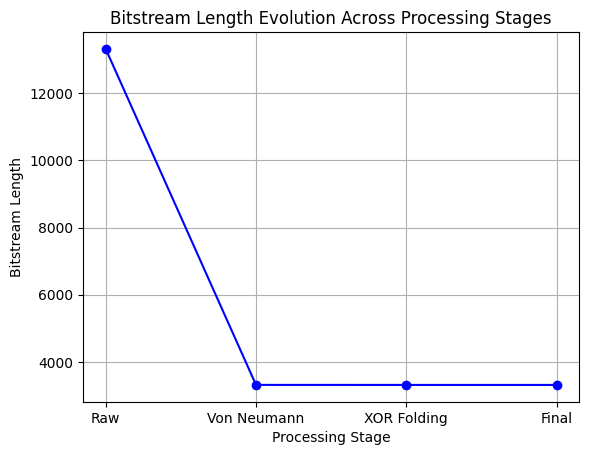

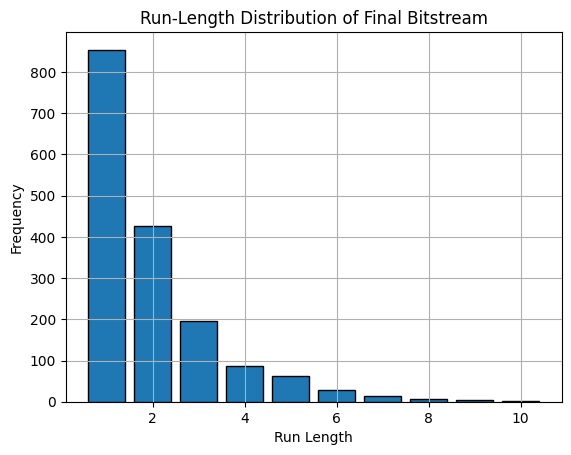

In [34]:
# Example data generation (replace with actual data source processing logic)
def generate_raw_bitstream(data_source=None):
    """Simulates generating a raw bitstream from a data source."""
    # Replace this logic with actual extraction process (e.g., read from file/video)
    np.random.seed(42)  # For reproducibility
    raw_bitstream = np.random.randint(0, 2, 13312)  # Simulated raw bitstream of length 13312
    return raw_bitstream

def von_neumann_extraction(raw_bitstream):
    """Applies Von Neumann extraction to remove bias."""
    extracted_bits = []
    for i in range(0, len(raw_bitstream) - 1, 2):
        if raw_bitstream[i] != raw_bitstream[i + 1]:
            extracted_bits.append(raw_bitstream[i])
    return np.array(extracted_bits)

def xor_folding(bitstream):
    """Performs XOR folding for further randomness extraction."""
    folded_bits = np.bitwise_xor(bitstream[:-1], bitstream[1:])
    return folded_bits

# Step 1: Generate raw bitstream
raw_bitstream = generate_raw_bitstream()

# Step 2: Apply Von Neumann extraction
vn_bitstream = von_neumann_extraction(raw_bitstream)

# Step 3: Apply XOR folding
xor_bitstream = xor_folding(vn_bitstream)

# Step 4: Final processed bitstream
final_bitstream = xor_bitstream

# Step 5: Calculate bitstream lengths
raw_length = len(raw_bitstream)
after_vn_length = len(vn_bitstream)
after_xor_length = len(xor_bitstream)
final_length = len(final_bitstream)

# Analysis and Visualization

# 1. Frequency Histogram
plt.figure()
plt.hist(final_bitstream, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Bit Value')
plt.ylabel('Frequency')
plt.title('Frequency Histogram of Final Bitstream')
plt.grid(True)
plt.show()

# 2. QQ Plot
plt.figure()
stats.probplot(final_bitstream, dist="uniform", plot=plt)
plt.title('QQ Plot of Final Bitstream vs. Uniform Distribution')
plt.grid(True)
plt.show()

# 3. Autocorrelation Plot
def autocorrelation(x, lag):
    n = len(x)
    return np.corrcoef(x[:n-lag], x[lag:])[0, 1]

max_lag = 50
lags = np.arange(1, max_lag)
ac_values = [autocorrelation(final_bitstream, lag) for lag in lags]

plt.figure()
plt.stem(lags, ac_values)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Final Bitstream')
plt.grid(True)
plt.show()

# 4. Bitstream Evolution Plot
stages = ['Raw', 'Von Neumann', 'XOR Folding', 'Final']
lengths = [raw_length, after_vn_length, after_xor_length, final_length]

plt.figure()
plt.plot(stages, lengths, marker='o', linestyle='-', color='blue')
plt.xlabel('Processing Stage')
plt.ylabel('Bitstream Length')
plt.title('Bitstream Length Evolution Across Processing Stages')
plt.grid(True)
plt.show()

# 5. Run-Length Distribution Plot
def run_lengths(bitstream):
    if len(bitstream) == 0:
        return np.array([])
    runs = []
    current_run = 1
    for i in range(1, len(bitstream)):
        if bitstream[i] == bitstream[i-1]:
            current_run += 1
        else:
            runs.append(current_run)
            current_run = 1
    runs.append(current_run)
    return np.array(runs)

runs = run_lengths(final_bitstream)
plt.figure()
plt.hist(runs, bins=np.arange(1, np.max(runs)+2)-0.5, edgecolor='black', rwidth=0.8)
plt.xlabel('Run Length')
plt.ylabel('Frequency')
plt.title('Run-Length Distribution of Final Bitstream')
plt.grid(True)
plt.show()
